# Spatial display for Wetlands Insight Tool results <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with only the `NCI VDI` environment


* **Special requirements:** 
    * If running on the [NCI](https://nci.org.au/), ensure that `module load dea` is   run prior to launching this notebook
    * Check you have the latest version of the `wit_tooling package` by 
      copying and pasting the following code into a cell below and running the cell
    `!pip install --user git+git://github.com/GeoscienceAustralia/wit_tooling`
      
      
* **Products used:** 
    * Collection 2 Landsat Surface Reflectance: 
    [ls5_nbart_albers](https://explorer.dea.ga.gov.au/ls5_nbart_albers),
    [ls7_nbart_albers](https://explorer.dea.ga.gov.au/ls7_nbart_albers),
    [ls8_nbart_albers](https://explorer.dea.ga.gov.au/ls8_nbart_albers)
    * Collection 2 Landsat Fractional Cover, 
    generated using the Joint Remote Sensing Research Program algorithm: 
    [ls5_fc_albers](https://explorer.dea.ga.gov.au/ls5_fc_albers),
    [ls7_fc_albers](https://explorer.dea.ga.gov.au/ls7_fc_albers),
    [ls8_fc_albers](https://explorer.dea.ga.gov.au/ls8_fc_albers)
    * Water Observations from Space, 
    generated using the Geoscience Australia Algorithm:
    [wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers)



## Background
The Spatial Wetlands Insight Tool is a tool in development to display the coverage of water, "wetness" and vegetation fractional cover in a wetland spatially. It is generated off existing Wetlands Insight Tool temporal runs. 

## Description
This notebook uses an existing Wetlands Insight Tool temporal plot, 
generated from an existing WIT run, to create a spatial plot of water, "wetness", green/photosynthetic vegetation, dry/non-photosynthetic vegetation, and bare soil for a chosen observation date. 

1. First we load the existing WIT data from either: 
    * a saved csv location
    * a shapefile to retrieve the existing WIT data from the database of previous runs
    * a csv from an Amazon s3 data bucket
2. Then we choose a time of interest to plot Spatial WIT
3. Finally we output Spatial WIT to a file for each cover type
***

Before running this notebook:
-----------------------------
* Follow the instructions under `Special Requirements` above to load `dea` and install `wit_tooling`

## Load packages

In [1]:
# import all the necessary packages in this cell
from bokeh.colors import RGB
from bokeh.models import LinearColorMapper
import datetime 
import pandas as pd
import numpy as np
import fiona
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datacube.utils.cog import write_cog

from datetime import timedelta

from os import path
import os, sys, logging
import seaborn as sns
import ssl

from wit_tooling import load_wit_data, query_datasets, construct_product, load_wofs_fc, generate_raster, spatial_wit

In [2]:
_LOG = logging.getLogger(__name__)
stdout_hdlr = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('[%(asctime)s.%(msecs)03d - %(levelname)s] %(message)s')
stdout_hdlr.setFormatter(formatter)
_LOG.addHandler(stdout_hdlr)
_LOG.setLevel(logging.DEBUG)

### Global variables
If you are using a shapefile, csv file, or Amazon s3 link to the existing WIT run, 
the path must be set in the cell below this cell:

* `shapefile`: NCI path to shapefile 
(e.g. `'/g/data1a/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'`). 
You must have permissions to the project directory,
and the shapefile must be in [Australian Albers EPSG 3577 projection](https://spatialreference.org/ref/epsg/gda94-australian-albers/)
* `csv_file`: NCI path to WIT results CSV (e.g. `'/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'`)
* `pd_yaml`: Yaml file necessary to generate WIT 
e.g. `'/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'`). 
Specifies input datasets.
* `s3_url`: Amazon s3 url link to pre-generated WIT csvs folder 
(e.g. `'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3'`). 


In [3]:
# put global variables in this cell
shapefile = '/g/data/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'
#csv_file = '/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'
pd_yaml = '/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'
s3_url = 'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv'

In [4]:
def save_geotiff(spatial_wit_xr, filename, force=False):
    """
        save spatial WIT result to geotiffs, each band will be output to individual tiff
        input:
            an xarray Dataset of spatial WIT
            overwrite existing file if force=True, otherwise no output
        output:
            multiple cloud-optimized geotiffs (cogs) on disk
    """
    for var in spatial_wit_xr.data_vars:       
        #create file name per band
        band_output = file_name + "_" + var + ".tif"
        if path.exists(band_output):
            _LOG.warning("output geotif %s exists", band_output)
            if force:
                _LOG.warning("existing geotif %s will be overwritten", band_output)
                os.remove(band_output)
            else:
                continue
        spatial_wit_xr[var].attrs.update(spatial_wit_xr.attrs)
        write_cog(spatial_wit_xr[var], band_output, blocksize=16)
    return

## Load WIT data using one of the methods in the cell below

In [5]:
# A list we wanna explore
#poly_candidates = {1: 1, 5: 5, 116: 116, 103: 103, 2: 2, 112: 112}
poly_candidates = {42:42}

In [6]:
# todo: iterate over all possible loading routes,
# i.e., database and csv on s3 (not responsible for local csv, users supposed to know)
# load wit data from database with a chosen shape
with fiona.open(shapefile) as allshapes:
    shape_crs = allshapes.crs_wkt
    shape_list = iter(allshapes)
    while True:
        shape = next(shape_list)
        if int(shape['id']) == poly_candidates[42]:
            break
    #polyName = shape['properties'].get('WetlandNam', '')
    poly_outline = np.array(shape['geometry']['coordinates'][0])
   # s3_filename = 'area_percent_' + shape['id'] + '_0.csv'
    wit_data = load_wit_data(s3_url='https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3/Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv')

### Check the shapefile to make sure we've got the correct polygon

In [7]:
shape_df = gpd.read_file(shapefile)

In [8]:
shape_df[42:43]

,REFCODE,RAMSAR_NAM,WETLAND_NA,STATE,JURISDICTI,DESIGNATIO,TOTAL_SITE,GAZETTED_A,SOURCE,METADATA_U,WETLANDSDB,AREA_HA,geometry
42,17,Kerang Wetlands,Hird Swamp,VIC,VIC,1982-12-15,0.0,9419.0,Department of Environment and Primary Industri...,http://services.land.vic.gov.au/SpatialDatamar...,http://www.environment.gov.au/cgi-bin/wetlands...,433.68127,"POLYGON ((1090599.724 -3968110.105, 1090900.93..."


In [9]:
#Check that #42 is Hird Swamp
print(shape_df['WETLAND_NA'][42])
polyName = shape_df['WETLAND_NA'][42]
#shape_df['geometry'][42]

Hird Swamp


### Spatial wit for the chosen shape

In [10]:
# it's helpful to get the location of data rather than load them
# and it will save you time without querying database multiple times
time_range = (wit_data.utc_time.min(), wit_data.utc_time.max())

In [11]:
#build a product for our data using the yaml file to specify which datasets we need
fc_product = construct_product(pd_yaml)
datasets = query_datasets(fc_product, shape, shape_crs, time_range)
_LOG.debug("Query datasets %s", datasets)

[2021-05-24 16:16:44,510.510 - DEBUG] Query datasets <VirtualDatasetBox of shape {'time': 1091, 'y': 152, 'x': 74}>


Retrieve spatial wit for the dates we have chosen to show in the WIT paper

In [13]:

#setup dates for the paper figure 
paper_dates = [datetime.date(1987,9,30),
              datetime.date(1998,4,30),
              datetime.date(1999,4,1),
              datetime.date(2009,4,4),
              datetime.date(2011,1,28),
              datetime.date(2017,9,26),
              datetime.date(2019,6,28)]

#convert the times (from the paper figure) into timestamps by finding the closest times, and hoping they match
paper_ixs = [abs(wit_data.utc_time-t).argmin() for t in pd.to_datetime(paper_dates)]

# take time slice to init spatial wit plot
time_slice = np.datetime64(wit_data.utc_time[paper_ixs[0]])
_LOG.debug("load time slice %s", time_slice)

#load the first data array for spatial wit
fc_wofs_data = load_wofs_fc(fc_product, datasets, time_slice)

#load our time slices in a loop
time_slices = [np.datetime64(wit_data.utc_time[paper_ixs[0]])]

for i in range(0,6):
    # set the time slice, load the time slice, then concatenate the arrays. 
    time_slice = np.datetime64(wit_data.utc_time[paper_ixs[i+1]])
    time_slices.append(time_slice)
    _LOG.debug("load time slice %s", time_slice)
    fc_wofs_data_new = load_wofs_fc(fc_product, datasets, time_slice)
    #add the new one to the existing one and hope it works
    fc_wofs_data = xr.concat([fc_wofs_data, fc_wofs_data_new],'time')

[2021-05-24 16:16:59,737.737 - DEBUG] load time slice 1987-09-30T23:42:36.500000
[2021-05-24 16:17:01,762.762 - DEBUG] load time slice 1998-04-30T23:46:24.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-05-24 16:17:03,645.645 - DEBUG] load time slice 1999-04-01T23:47:56.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-05-24 16:17:05,420.420 - DEBUG] load time slice 2009-04-04T00:02:23.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-05-24 16:17:07,744.744 - DEBUG] load time slice 2011-01-28T23:59:10.500000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-05-24 16:17:09,744.744 - DEBUG] load time slice 2017-09-26T00:09:26.000000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


[2021-05-24 16:17:11,049.049 - DEBUG] load time slice 2019-06-28T00:09:07.000000


/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))
/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {'crs': 'EPSG:3577'}
  .format(first, other))


mask spatial wit by the geometry of given polygon

In [14]:
# first parameter of generate_raster is a tuple of (shape geometry, [integer of shape id])
mask = generate_raster([(shape['geometry'], int(shape['id']))], datasets.geobox)
fc_wofs_perc = spatial_wit(fc_wofs_data, mask)

/g/data/v10/public/modules/dea/20201217/lib/python3.6/site-packages/datacube/utils/geometry/_base.py:301: DeprecationWarning: Please use `str(crs)` instead of `crs.crs_str`
  warnings.warn("Please use `str(crs)` instead of `crs.crs_str`", category=DeprecationWarning)


get our temporal wit data into a form that we can plot nicely

In [15]:
if wit_data.water.max() <= 1.0:
    #multiply our pandas bare, wet, green, dry, water by 100 to make plotting perc
    wit_data.iloc[:,1:] = wit_data[wit_data.columns[1:]].apply(lambda x: x * 100)

In [20]:
fc_wofs_perc.time

<xarray.DataArray 'time' (time: 7)>
array(['1987-09-30T23:42:36.500000000', '1998-04-30T23:46:24.500000000',
       '1999-04-01T23:47:56.500000000', '2009-04-04T00:02:23.500000000',
       '2011-01-28T23:59:10.500000000', '2017-09-26T00:09:26.000000000',
       '2019-06-28T00:09:07.000000000'], dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 1987-09-30T23:42:36.500000 ... 2019-06...
Attributes:
    units:    seconds since 1970-01-01 00:00:00

ok our two datasets, wit_data for the WIT plot and fc_wofs_data for our spatial WIT plots are ready. 

Create a wit temporal plot with wit spatial wit plots above it

In [22]:
#set up color palette for WIT plot
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"],
       sns.xkcd_rgb['grey']]  

In [32]:
#get headings for spatial wit from our scene indices
scene_days= np.datetime_as_string(time_slices, unit = 'D')
scene_days

array(['1987-09-30', '1998-04-30', '1999-04-01', '2009-04-04',
       '2011-01-28', '2017-09-26', '2019-06-28'], dtype='<U28')

In [49]:
fc_wofs_perc

<xarray.Dataset>
Dimensions:      (time: 7, x: 74, y: 152)
Coordinates:
  * x            (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.091e+06 1.091e+06
    spatial_ref  int32 3577
  * y            (y) float64 -3.968e+06 -3.968e+06 ... -3.972e+06 -3.972e+06
  * time         (time) datetime64[ns] 1987-09-30T23:42:36.500000 ... 2019-06...
Data variables:
    BS           (time, y, x) int16 -127 -127 -127 -127 ... -127 -127 -127 -127
    PV           (time, y, x) int16 -127 -127 -127 -127 ... -127 -127 -127 -127
    NPV          (time, y, x) int16 -127 -127 -127 -127 ... -127 -127 -127 -127
    TCW          (time, y, x) int16 -127 -127 -127 -127 ... -127 -127 -127 -127
    water        (time, y, x) int16 -127 -127 -127 -127 ... -127 -127 -127 -127
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

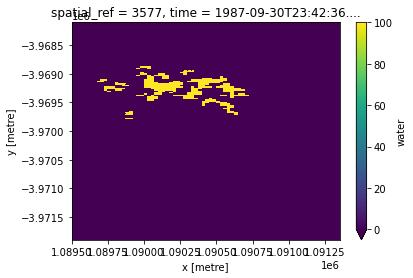

In [43]:
fc_wofs_perc.water.isel(time=0).plot(vmin=0, vmax=100)

In [105]:
fc_wofs_perc_mpl = fc_wofs_perc.where(fc_wofs_perc!=-127)

In [107]:
fc_wofs_perc_mpl

<xarray.Dataset>
Dimensions:      (time: 7, x: 74, y: 152)
Coordinates:
  * x            (x) float64 1.09e+06 1.09e+06 1.09e+06 ... 1.091e+06 1.091e+06
    spatial_ref  int32 3577
  * y            (y) float64 -3.968e+06 -3.968e+06 ... -3.972e+06 -3.972e+06
  * time         (time) datetime64[ns] 1987-09-30T23:42:36.500000 ... 2019-06...
Data variables:
    BS           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    PV           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    NPV          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    TCW          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    water        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [101]:
#set up color palette for spatial wit OLD plot
import matplotlib as mpl

green_colors = ('#00000000',sns.xkcd_rgb["grass"])
brown_colors = ('#00000000',sns.xkcd_rgb["beige"])
bare_colors  = ('#00000000',sns.xkcd_rgb["brown"])
norm = mpl.colors.NoNorm(0,1)
#thresholded TCW is boolean type, so need a two-step color map with transparent and a color
tcw_colors = ('#00000000',sns.xkcd_rgb["neon blue"]) #neon blue to transparent
#we use "NoNorm" because our data should only come in 0 and 1s
#norm = mpl.colors.NoNorm(0,1)
vnorm = mpl.colors.Normalize(vmin=0, vmax=100)
#thresholded wofs is boolean type, so need a two-step color map with transparent and a color
wofs_colors = ('#00000000',sns.xkcd_rgb["cobalt blue"]) #cobalt blue to transparent

fc_norm= norm

In [118]:
t = 6

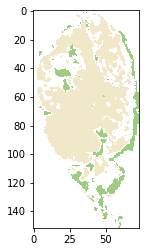

In [119]:
#plot the results to check they look roughly like what we are expecting
plt.imshow(fc_wofs_perc_mpl.TCW.isel(time=t),cmap=mpl.colors.ListedColormap(colors =tcw_colors), norm = vnorm, alpha =0.6)
plt.imshow(fc_wofs_perc_mpl.water.isel(time=t),cmap=mpl.colors.ListedColormap(colors =wofs_colors), norm = vnorm, alpha =0.6)
plt.imshow(fc_wofs_perc_mpl.PV.isel(time=t),cmap=mpl.colors.ListedColormap(colors =green_colors), norm = vnorm, alpha =0.6)
plt.imshow(fc_wofs_perc_mpl.NPV.isel(time=t),cmap=mpl.colors.ListedColormap(colors =brown_colors), norm = vnorm, alpha =0.6)
plt.imshow(fc_wofs_perc_mpl.BS.isel(time=t),cmap=mpl.colors.ListedColormap(colors =bare_colors), norm = vnorm, alpha =0.6)

In [ ]:
###us numpy to turn data into a float so the colormap doesn't break
plt.imshow(tcw.isel(time=scene).astype(np.float32), cmap=mpl.colors.ListedColormap(colors=tcw_colors), norm=tcw_norm, alpha =0.6)
plt.imshow(wet_wofs.water.isel(time=scene),cmap=mpl.colors.ListedColormap(colors =wofs_colors), norm = wofs_norm, alpha =0.5 )
#note shadow wofs not plotted here!!!!!!! #FIXME

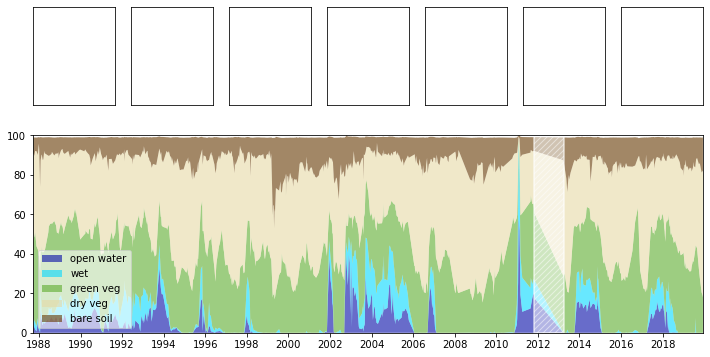

In [24]:
 #....aaaand ---- trying with matplotlib gridplots instead
    
def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):

        #turn off the ticks for everything except the last one
        if i <=6:    
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)  
            for tl in ax.get_xticklabels() + ax.get_yticklabels():
                tl.set_visible(False)
        #for the WIT plot, set up the axes
        if i == 7: 
            #set date ticks every year
            years = mdates.YearLocator(2)
            yearsFmt = mdates.DateFormatter('%Y')
            ax.xaxis.set_major_locator(years)
            ax.xaxis.set_major_formatter(yearsFmt)
            #ax.yaxis.set_ticks(np.arange(0,110,10))
            
            
#set the figure size and parameters            
f = plt.figure(figsize=(12,6))

gs = GridSpec(2, 7,
                       #width_ratios=[1,8],
                      height_ratios=[1,2]
                       )

# setup the gridspec for subplots
ax1 = f.add_subplot(gs[0,0])
ax2 = f.add_subplot(gs[0,1])
ax3 = f.add_subplot(gs[0,2])
ax4 = f.add_subplot(gs[0,3])
ax5 = f.add_subplot(gs[0,4])
ax6 = f.add_subplot(gs[0,5])
ax7 = f.add_subplot(gs[0,6])
ax8 = f.add_subplot(gs[1,:])

make_ticklabels_invisible(f)

#spatial wit plot (old method - using dominant percentage)
for i, ax in enumerate(fig.axes):

    #turn off the ticks for everything except the last one
    if i <=6:    
        

#then our witplot at the end
ax8.stackplot(wit_data.utc_time.values, 
              wit_data.water, 
              wit_data.wet, 
              wit_data.green, 
              wit_data.dry,
              wit_data.bare,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                      '_nodata'
                   ], 
              colors=pal, alpha = 0.6)

# #add a legend and a tight plot box
ax8.legend(loc='lower left', framealpha=0.6)
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime.datetime(2011,11,1)
LS5_8_gap_end = datetime.datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)

gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start

#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax8.add_patch(slc_rectangle)

#set axis limits to the min and maxto remove white space around the plot
ax8.axis(xmin = wit_data.utc_time.values[0], xmax = wit_data.utc_time.values[-1], ymin = 0, ymax = 100)

plt.show()    
    

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 24 2021

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`no_testing`,:index:`NCI compatible`,:index:`landsat 5`, :index:`landsat 7`,  :index:`landsat 8`, :index:`dea_plotting`, :index:`time series`